# 인공지능기초와활용
## Midterm project 결과 분석 보고서
### 컴퓨터공학과 19101281 조영효




---
- GPU 확인 및 사용 강제


In [16]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16672597692086462309,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22848617856
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7227639726148239374
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Base code 작성(Chat GPT)

- 필요 모듈 import

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

- CIFAR10 Dataset load 및 전처리

In [22]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode the labels
num_classes = 10
y_train = np.eye(num_classes)[y_train.reshape(-1)]
y_test = np.eye(num_classes)[y_test.reshape(-1)]

- Hyper parameter 설정 및 모델 complile

In [23]:
model = Sequential()

# Add Convolutional, Batch Normalization, Activation, and Pooling layers
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add additional layers, Dropout, Dense, and Batch Normalization layers
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [24]:
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [25]:
batch_size = 64
epochs = 100
validation_split = 0.1

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, shuffle=True)


Epoch 1/100
704/704 [==============================] - 5s 6ms/step - loss: 1.7022 - accuracy: 0.4320 - val_loss: 1.2527 - val_accuracy: 0.5486
Epoch 2/100
704/704 [==============================] - 3s 5ms/step - loss: 1.0657 - accuracy: 0.6256 - val_loss: 2.4966 - val_accuracy: 0.3202
Epoch 3/100
704/704 [==============================] - 3s 5ms/step - loss: 0.9293 - accuracy: 0.6725 - val_loss: 1.0918 - val_accuracy: 0.6168
Epoch 4/100
704/704 [==============================] - 3s 5ms/step - loss: 0.8138 - accuracy: 0.7178 - val_loss: 0.9721 - val_accuracy: 0.6588
Epoch 5/100
704/704 [==============================] - 3s 5ms/step - loss: 0.7217 - accuracy: 0.7463 - val_loss: 0.9856 - val_accuracy: 0.6632
Epoch 6/100
704/704 [==============================] - 3s 5ms/step - loss: 0.6376 - accuracy: 0.7743 - val_loss: 1.1082 - val_accuracy: 0.6538
Epoch 7/100
704/704 [==============================] - 3s 5ms/step - loss: 0.5703 - accuracy: 0.8020 - val_loss: 1.3398 - val_accuracy: 0.5918

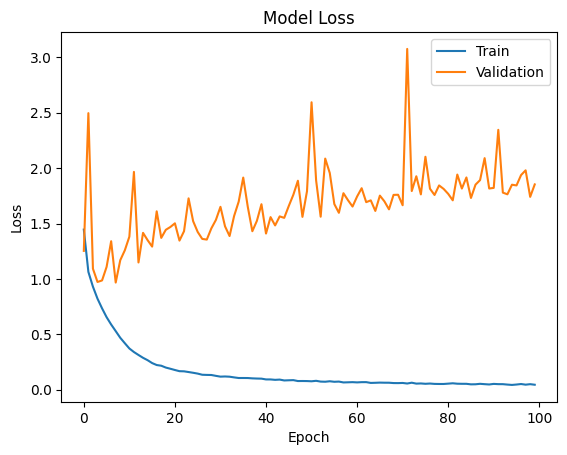

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


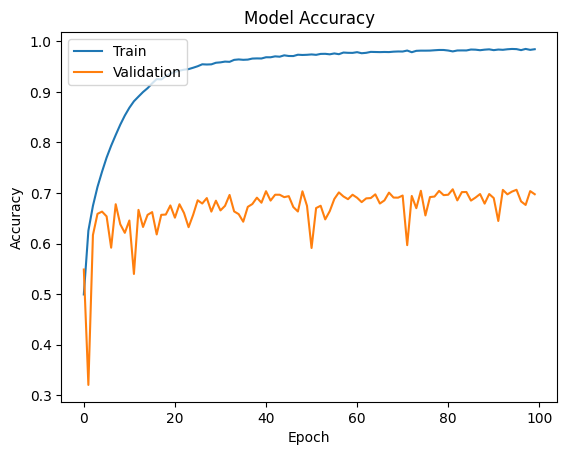

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [28]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


313/313 [==============================] - 1s 3ms/step - loss: 1.8782 - accuracy: 0.6822
Test loss: 1.8781713247299194
Test accuracy: 0.682200014591217


- 위 학습 방법은 Test accuracy 목표치인 50%를 초과했지만, 좋은 모델이라고 할 수 없다.
- 30epoch 이상부터는 유의미한 성능 향상이 보이지 않았다.
- 그래서 Train accuracy는 100epoch에서 거의 1에 수렴하지만 validation accuracy는 0.7정도로, train data에 심하게 overfitting된 모델이라 볼 수 있다.
- 또한 validation loss는 학습이 진행될 때 마다 오히려 증가하는 모습을 보이므로 아래에서 다른 방법들을 사용해 성능을 향상시켜 보겠다.

## Refactoring

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
from sklearn.model_selection import train_test_split

In [61]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

num_classes = 10
y_train = np.eye(num_classes)[y_train.reshape(-1)]
y_test = np.eye(num_classes)[y_test.reshape(-1)]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


- 모델 구조 변경, layer 추가
- activation을 relu에서 elu로 변경 -> 변경 후 초반 학습이 더 빠르게 됨을 확인함.
- L2규제 적용(1e-4)

In [62]:
weight_decay = 1e-4
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_30 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_31 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)       

- ImageDataGenerator를 활용해 Data Augmentation, (성능향상, overfitting 방지)

In [63]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.1
    )
datagen.fit(x_train)

- learning rate scheduling 적용

In [64]:
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 60:
        lr = 0.0005
    if epoch > 90:
        lr = 0.0003
    return lr

- optimizer를 Adam에서 RMSprop으로 변경 -> 큰 차이는 발견하지 못했으나, 미세하게 성능이 더 좋은 것을 확인함.


- overfitting과 자원 낭비를 방지하기 위해, modelcheckpoint, earlystopping(patient=3)적용 -> epoch을 최대인 200으로 설정
-> patient를 3에서 7로 변경 validation accuracy가 들쭉날쭉한 경향이 보여 더 길게 봐야겠다 판단함.

In [65]:
batch_size = 64
epochs = 200

In [66]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001,decay=1e-6), metrics=['accuracy'])

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
                    verbose=1, validation_data=(x_val, y_val),
                    callbacks=[TensorBoard(log_dir='./graph', histogram_freq=0, write_graph=True, write_images=True),
                    LearningRateScheduler(lr_schedule), ModelCheckpoint('best_model.h5', save_best_only="True"),
                    EarlyStopping(patience=7, monitor='val_loss', restore_best_weights=True)])


Epoch 1/200
703/703 [==============================] - 11s 15ms/step - loss: 2.4265 - accuracy: 0.3325 - val_loss: 1.3308 - val_accuracy: 0.5816
Epoch 2/200
703/703 [==============================] - 9s 13ms/step - loss: 1.3863 - accuracy: 0.5515 - val_loss: 1.0915 - val_accuracy: 0.6538
Epoch 3/200
703/703 [==============================] - 9s 13ms/step - loss: 1.1537 - accuracy: 0.6238 - val_loss: 0.9234 - val_accuracy: 0.7140
Epoch 4/200
703/703 [==============================] - 9s 13ms/step - loss: 1.0231 - accuracy: 0.6750 - val_loss: 1.2186 - val_accuracy: 0.6402
Epoch 5/200
703/703 [==============================] - 9s 13ms/step - loss: 0.9587 - accuracy: 0.6952 - val_loss: 0.8751 - val_accuracy: 0.7410
Epoch 6/200
703/703 [==============================] - 9s 13ms/step - loss: 0.8944 - accuracy: 0.7254 - val_loss: 0.8692 - val_accuracy: 0.7374
Epoch 7/200
703/703 [==============================] - 9s 13ms/step - loss: 0.8645 - accuracy: 0.7344 - val_loss: 0.8155 - val_accuracy

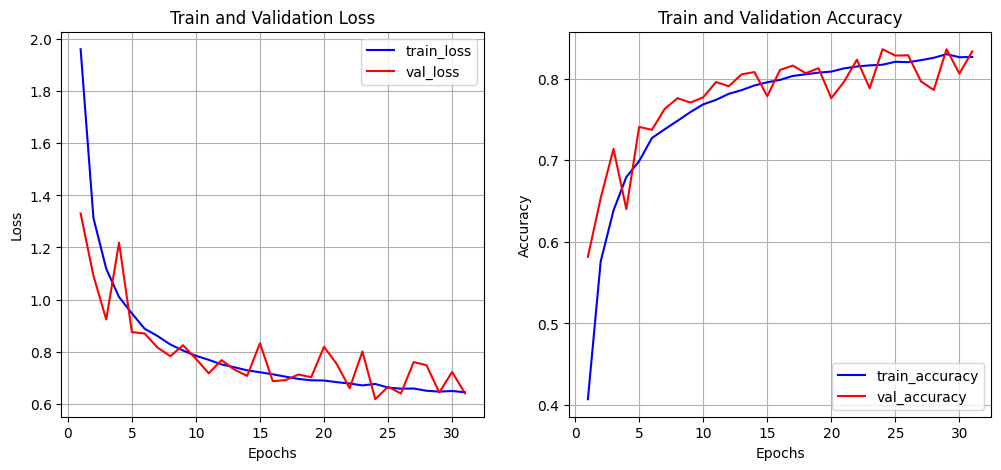

In [67]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

- 모델 성능 평가

In [68]:

model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.6372 - accuracy: 0.8319


[0.6371774673461914, 0.8319000005722046]